In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/bert

In [ ]:
%%capture
!pip install shap
!pip install interpret
!pip install nltk
!pip install wordcloud
!pip install lightgbm

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import interpret.glassbox
import lightgbm as lgb
import shap
import random
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stopwords = stopwords.words('english')

from preprocess_data import read_dublin_data, read_sentiment_data, preprocess_data
from evaluate import evaluate_model


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Parameters

In [46]:
N_SAMPLE = 100000
MAX_FEATURES = 15000
N_TWEET_PRINT = 10

# Read Data

In [48]:
%%capture
filename = "/content/gdrive/MyDrive/bert/Sentiment140-train.csv"
df_train = read_sentiment_data(filename)
df_train = df_train.sample(N_SAMPLE).reset_index(drop=True)

In [ ]:
%%capture
filename = "/content/gdrive/MyDrive/bert/Sentiment140-test.csv"
df_test = read_sentiment_data(filename)

In [ ]:
%%capture
filename = "/content/gdrive/MyDrive/bert/citypulse.dublin_city_council.test.csv"
df_dublin = read_dublin_data(filename)

In [50]:
df_train['split'] = "train"
df_test['split'] = "test"
df_all = pd.concat([df_train, df_test])

In [51]:
df_dublin = preprocess_data(df_dublin, stopwords)
df_train = preprocess_data(df_train, stopwords)
df_test = preprocess_data(df_test, stopwords)
df_all = preprocess_data(df_all, stopwords)

In [52]:
word_vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', sublinear_tf=True, strip_accents='unicode',
                                  stop_words='english', ngram_range=(1, 1), max_features=MAX_FEATURES)
word_vectorizer.fit(df_all['text_clean'])

TfidfVectorizer(max_features=15000, stop_words='english',
                strip_accents='unicode', sublinear_tf=True,
                token_pattern='\\w{1,}')

# Split train/test features and target

In [53]:
train_text = df_all.loc[df_all['split']=="train", "text_clean"]
test_text = df_all.loc[df_all['split']=="test", "text_clean"]
all_text = df_all["text_clean"]
y_train = df_all.loc[df_all['split']=="train", "sentiment"]
y_test = df_all.loc[df_all['split']=="test", "sentiment"]
y_all_text = df_all["sentiment"]

In [54]:
x_dublin = df_dublin["text_clean"]
y_dublin = df_dublin["sentiment"]

In [55]:
train_features = word_vectorizer.transform(train_text)
test_features = word_vectorizer.transform(test_text)
all_features = word_vectorizer.transform(all_text)
dublin_features = word_vectorizer.transform(x_dublin)

In [56]:
df_train_features = pd.DataFrame(data = train_features.toarray())
df_train_features.columns = word_vectorizer.get_feature_names()

df_test_features = pd.DataFrame(data = test_features.toarray())
df_test_features.columns = word_vectorizer.get_feature_names()

df_dublin_features = pd.DataFrame(data = dublin_features.toarray())
df_dublin_features.columns = word_vectorizer.get_feature_names()

In [57]:
train_lgb = lgb.Dataset(df_train_features, label=y_train)
test_lgb = lgb.Dataset(df_test_features, label=y_test)
dublin_lgb = lgb.Dataset(df_dublin_features, label=y_dublin)

# Fit LightGBM model

In [58]:
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

model = lgb.train(parameters,
                       train_lgb,
                       valid_sets=test_lgb,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.217600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[1]	valid_0's auc: 0.647717
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.626321
[3]	valid_0's auc: 0.624739
[4]	valid_0's auc: 0.625861
[5]	valid_0's auc: 0.628173
[6]	valid_0's auc: 0.638693
[7]	valid_0's auc: 0.642509
[8]	valid_0's auc: 0.655037
[9]	valid_0's auc: 0.6664
[10]	valid_0's auc: 0.661766
[11]	valid_0's auc: 0.660992
[12]	valid_0's auc: 0.664366
[13]	valid_0's auc: 0.663122
[14]	valid_0's auc: 0.668539
[15]	valid_0's auc: 0.670156
[16]	va

[264]	valid_0's auc: 0.765675
[265]	valid_0's auc: 0.765675
[266]	valid_0's auc: 0.766179
[267]	valid_0's auc: 0.766214
[268]	valid_0's auc: 0.766336
[269]	valid_0's auc: 0.766631
[270]	valid_0's auc: 0.766875
[271]	valid_0's auc: 0.766823
[272]	valid_0's auc: 0.767466
[273]	valid_0's auc: 0.767501
[274]	valid_0's auc: 0.767501
[275]	valid_0's auc: 0.767935
[276]	valid_0's auc: 0.768074
[277]	valid_0's auc: 0.76797
[278]	valid_0's auc: 0.768144
[279]	valid_0's auc: 0.768787
[280]	valid_0's auc: 0.768805
[281]	valid_0's auc: 0.7691
[282]	valid_0's auc: 0.768266
[283]	valid_0's auc: 0.768266
[284]	valid_0's auc: 0.767866
[285]	valid_0's auc: 0.768005
[286]	valid_0's auc: 0.768196
[287]	valid_0's auc: 0.768422
[288]	valid_0's auc: 0.768214
[289]	valid_0's auc: 0.768161
[290]	valid_0's auc: 0.767979
[291]	valid_0's auc: 0.767092
[292]	valid_0's auc: 0.768361
[293]	valid_0's auc: 0.768587
[294]	valid_0's auc: 0.769144
[295]	valid_0's auc: 0.769213
[296]	valid_0's auc: 0.769952
[297]	valid_0

[544]	valid_0's auc: 0.780472
[545]	valid_0's auc: 0.780507
[546]	valid_0's auc: 0.780489
[547]	valid_0's auc: 0.780072
[548]	valid_0's auc: 0.780107
[549]	valid_0's auc: 0.779863
[550]	valid_0's auc: 0.779881
[551]	valid_0's auc: 0.779672
[552]	valid_0's auc: 0.779776
[553]	valid_0's auc: 0.779776
[554]	valid_0's auc: 0.779776
[555]	valid_0's auc: 0.779707
[556]	valid_0's auc: 0.779724
[557]	valid_0's auc: 0.779829
[558]	valid_0's auc: 0.779724
[559]	valid_0's auc: 0.77955
[560]	valid_0's auc: 0.779411
[561]	valid_0's auc: 0.779394
[562]	valid_0's auc: 0.779776
[563]	valid_0's auc: 0.779707
[564]	valid_0's auc: 0.779481
[565]	valid_0's auc: 0.779376
[566]	valid_0's auc: 0.779229
[567]	valid_0's auc: 0.779437
[568]	valid_0's auc: 0.779107
[569]	valid_0's auc: 0.779003
[570]	valid_0's auc: 0.778759
[571]	valid_0's auc: 0.778777
[572]	valid_0's auc: 0.779037
[573]	valid_0's auc: 0.778638
[574]	valid_0's auc: 0.778759
[575]	valid_0's auc: 0.778777
[576]	valid_0's auc: 0.778603
[577]	valid

[821]	valid_0's auc: 0.786375
[822]	valid_0's auc: 0.786497
[823]	valid_0's auc: 0.786653
[824]	valid_0's auc: 0.786723
[825]	valid_0's auc: 0.786705
[826]	valid_0's auc: 0.786671
[827]	valid_0's auc: 0.786775
[828]	valid_0's auc: 0.786879
[829]	valid_0's auc: 0.786914
[830]	valid_0's auc: 0.78681
[831]	valid_0's auc: 0.786705
[832]	valid_0's auc: 0.786844
[833]	valid_0's auc: 0.786792
[834]	valid_0's auc: 0.786984
[835]	valid_0's auc: 0.787071
[836]	valid_0's auc: 0.786931
[837]	valid_0's auc: 0.786931
[838]	valid_0's auc: 0.787401
[839]	valid_0's auc: 0.787523
[840]	valid_0's auc: 0.787627
[841]	valid_0's auc: 0.787679
[842]	valid_0's auc: 0.787557
[843]	valid_0's auc: 0.787523
[844]	valid_0's auc: 0.787314
[845]	valid_0's auc: 0.787262
[846]	valid_0's auc: 0.787105
[847]	valid_0's auc: 0.787297
[848]	valid_0's auc: 0.787297
[849]	valid_0's auc: 0.787384
[850]	valid_0's auc: 0.787418
[851]	valid_0's auc: 0.787366
[852]	valid_0's auc: 0.786497
[853]	valid_0's auc: 0.786792
[854]	valid

[1099]	valid_0's auc: 0.792139
[1100]	valid_0's auc: 0.792174
[1101]	valid_0's auc: 0.792104
[1102]	valid_0's auc: 0.792261
[1103]	valid_0's auc: 0.791983
[1104]	valid_0's auc: 0.791948
[1105]	valid_0's auc: 0.791739
[1106]	valid_0's auc: 0.791496
[1107]	valid_0's auc: 0.7916
[1108]	valid_0's auc: 0.79167
[1109]	valid_0's auc: 0.791357
[1110]	valid_0's auc: 0.791496
[1111]	valid_0's auc: 0.791496
[1112]	valid_0's auc: 0.791687
[1113]	valid_0's auc: 0.791617
[1114]	valid_0's auc: 0.791757
[1115]	valid_0's auc: 0.791704
[1116]	valid_0's auc: 0.79167
[1117]	valid_0's auc: 0.791757
[1118]	valid_0's auc: 0.791826
[1119]	valid_0's auc: 0.791826
[1120]	valid_0's auc: 0.791826
[1121]	valid_0's auc: 0.791826
[1122]	valid_0's auc: 0.792052
[1123]	valid_0's auc: 0.792035
[1124]	valid_0's auc: 0.792156
[1125]	valid_0's auc: 0.792278
[1126]	valid_0's auc: 0.792487
[1127]	valid_0's auc: 0.792591
[1128]	valid_0's auc: 0.792574
[1129]	valid_0's auc: 0.792591
[1130]	valid_0's auc: 0.792626
[1131]	valid

In [59]:
predictions = model.predict(all_features)
df_all['sentiment_pred'] = predictions
df_all['sentiment_pred_class'] = df_all['sentiment_pred'].apply(lambda x: round(x))

In [60]:
df_dublin['sentiment_pred'] = model.predict(dublin_features)
df_dublin['sentiment_pred_class'] = df_dublin['sentiment_pred'].apply(lambda x: round(x))

### Metrics Train

In [61]:
y_hat = df_all.loc[df_all['split']=="train", "sentiment"]
y_pred = df_all.loc[df_all['split']=="train", "sentiment_pred_class"]
evaluate_model(y_hat, y_pred)

[[38034 11958]
 [ 8505 41503]]
              precision    recall  f1-score   support

           0       0.82      0.76      0.79     49992
           1       0.78      0.83      0.80     50008

    accuracy                           0.80    100000
   macro avg       0.80      0.80      0.80    100000
weighted avg       0.80      0.80      0.80    100000

Accuracy Score: 0.795


### Metrics Test

In [62]:
y_hat = df_all.loc[(df_all['split']=="test") & (df_all['sentiment']!=-1), "sentiment"]
y_pred = df_all.loc[(df_all['split']=="test") & (df_all['sentiment']!=-1), "sentiment_pred_class"]
evaluate_model(y_hat, y_pred)

[[127  50]
 [ 28 154]]
              precision    recall  f1-score   support

           0       0.82      0.72      0.77       177
           1       0.75      0.85      0.80       182

    accuracy                           0.78       359
   macro avg       0.79      0.78      0.78       359
weighted avg       0.79      0.78      0.78       359

Accuracy Score: 0.783
AUC: 0.782


### Metrics Dublin dataset

In [63]:
y_hat = df_dublin.loc[(df_dublin['sentiment']!=-1), "sentiment"]
y_pred = df_dublin.loc[(df_dublin['sentiment']!=-1), "sentiment_pred_class"]
evaluate_model(y_hat, y_pred)

[[648 352]
 [387 613]]
              precision    recall  f1-score   support

           0       0.63      0.65      0.64      1000
           1       0.64      0.61      0.62      1000

    accuracy                           0.63      2000
   macro avg       0.63      0.63      0.63      2000
weighted avg       0.63      0.63      0.63      2000

Accuracy Score: 0.630


### Metrics by category

In [64]:
for category in df_dublin['category'].unique():
    print(category)
    y_hat = df_dublin.loc[(df_dublin['sentiment']!=-1) & (df_dublin['category']!=category), "sentiment"]
    y_pred = df_dublin.loc[(df_dublin['sentiment']!=-1) & (df_dublin['category']!=category), "sentiment_pred_class"]
    evaluate_model(y_hat, y_pred)

Public Spaces
[[642 345]
 [383 609]]
              precision    recall  f1-score   support

           0       0.63      0.65      0.64       987
           1       0.64      0.61      0.63       992

    accuracy                           0.63      1979
   macro avg       0.63      0.63      0.63      1979
weighted avg       0.63      0.63      0.63      1979

Accuracy Score: 0.632
Community and Culture
[[570 288]
 [304 410]]
              precision    recall  f1-score   support

           0       0.65      0.66      0.66       858
           1       0.59      0.57      0.58       714

    accuracy                           0.62      1572
   macro avg       0.62      0.62      0.62      1572
weighted avg       0.62      0.62      0.62      1572

Accuracy Score: 0.623
Mobility
[[473 268]
 [304 511]]
              precision    recall  f1-score   support

           0       0.61      0.64      0.62       741
           1       0.66      0.63      0.64       815

    accuracy            

In [65]:
df_dublin['sentiment_pred_class'] = df_dublin['sentiment_pred'].astype(int)

# SHAP values of baseline model with test dataset 

 99%|===================| 495/498 [00:50<00:00]        

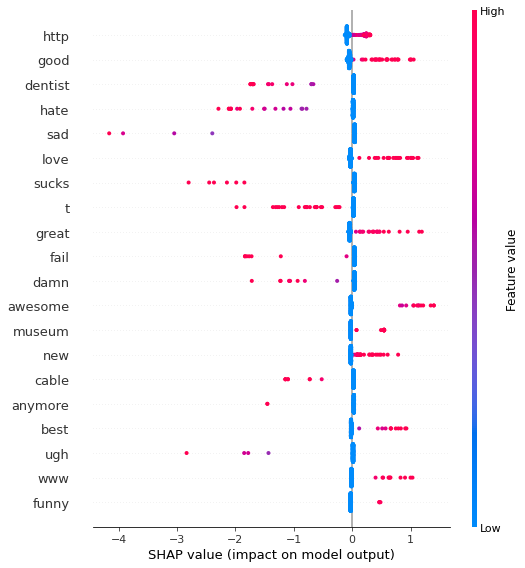

In [67]:
explainer = shap.TreeExplainer(model,
                                 df_test_features)
shap_values = explainer.shap_values(df_test_features)
X_test_array = test_features.toarray()
shap.summary_plot(shap_values,
                  X_test_array,
                  feature_names=word_vectorizer.get_feature_names())

# SHAP values of baseline model with dublin dataset 

100%|===================| 2993/3000 [05:03<00:00]        

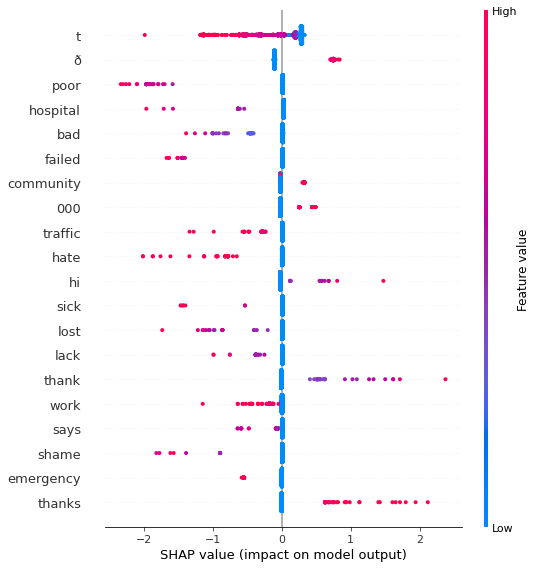

In [68]:
explainer = shap.TreeExplainer(model,
                                 df_dublin_features)
shap_values = explainer.shap_values(df_dublin_features)
X_test_array = dublin_features.toarray()
shap.summary_plot(shap_values,
                  X_test_array,
                  feature_names=word_vectorizer.get_feature_names())

# SHAP values of baseline model with test dataset only with right predictions

 99%|===================| 991/1000 [01:40<00:00]        

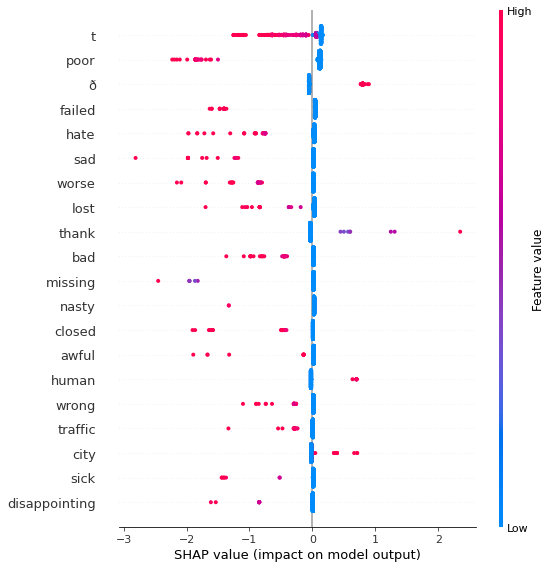

In [69]:
mask = df_dublin[df_dublin['sentiment'] == df_dublin['sentiment_pred_class']].index

explainer = shap.TreeExplainer(model,
                                 df_dublin_features.loc[mask])
shap_values = explainer.shap_values(df_dublin_features.loc[mask])
X_test_array = dublin_features[mask].toarray()
shap.summary_plot(shap_values,
                  X_test_array,
                  feature_names=word_vectorizer.get_feature_names())

# SHAP values of baseline model with test dataset only with wrong predictions

100%|===================| 1999/2000 [03:20<00:00]        

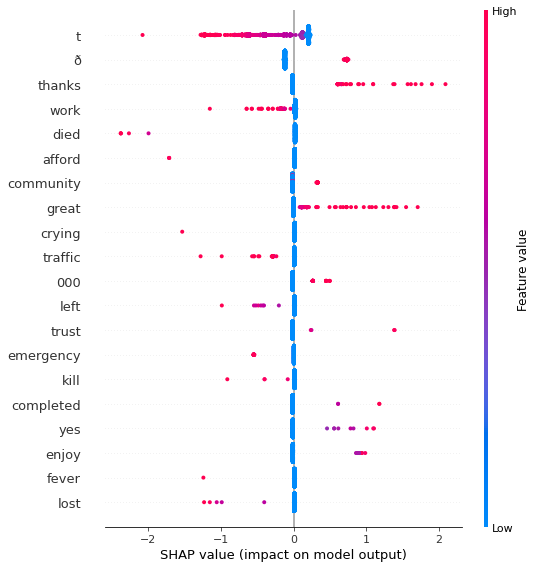

In [70]:
mask = df_dublin[df_dublin['sentiment'] != df_dublin['sentiment_pred_class']].index

explainer = shap.TreeExplainer(model,
                                 df_dublin_features.loc[mask])
shap_values = explainer.shap_values(df_dublin_features.loc[mask])
X_test_array = dublin_features[mask].toarray()
shap.summary_plot(shap_values,
                  X_test_array,
                  feature_names=word_vectorizer.get_feature_names())

# SHAP values for individual cases of wrong predictions

Tweet 1/10
Real sentiment: 1
Predicted sentiment: 0
@DanMulhall @EamonnMallie @MoLI_Museum .@DubCityCouncil #parks dept does great job all year round. Grma - I regularly walk through St Stephenâs Green &amp; am always grateful #Dublin


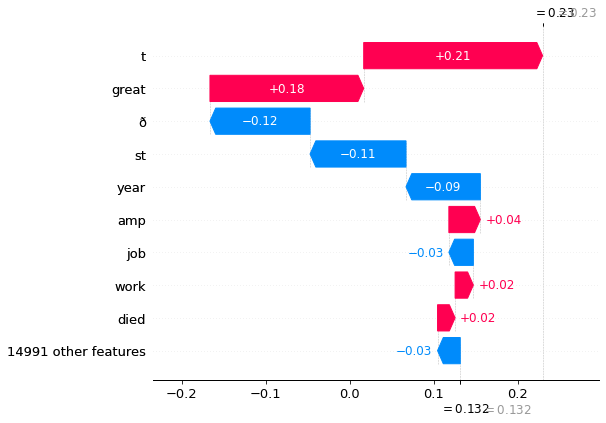

Tweet 2/10
Real sentiment: 1
Predicted sentiment: 0
Love my city and community!! Rallying together for what is right ðð½ðð½ðð½ðð½ @selenatwest @NinaWest 

Supporters rally outside Delaware Drag 101 class https://t.co/sCNRDZ9cvp


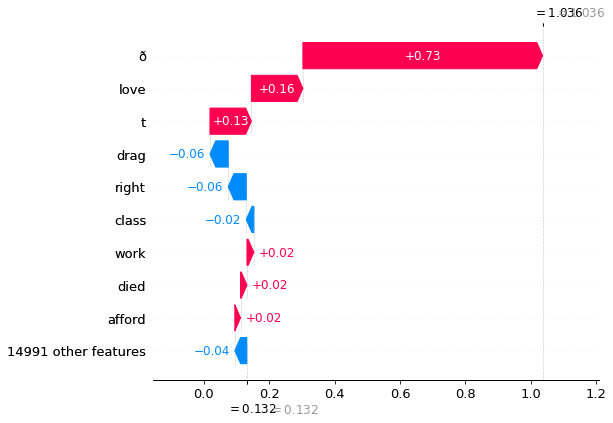

Tweet 3/10
Real sentiment: 1
Predicted sentiment: 0
Bringing shared #micromobility e-bike &amp; e-scooter solutions to bear on Dublinâs traffic congestion, will help our ranking enormously

Looking forward to @Dub_Bleeper @MobyMove new schemes + arrival of shared scooter operators in time also @smartdublin @jcudden @LordMayorDublin https://t.co/Adw9XsJOTQ


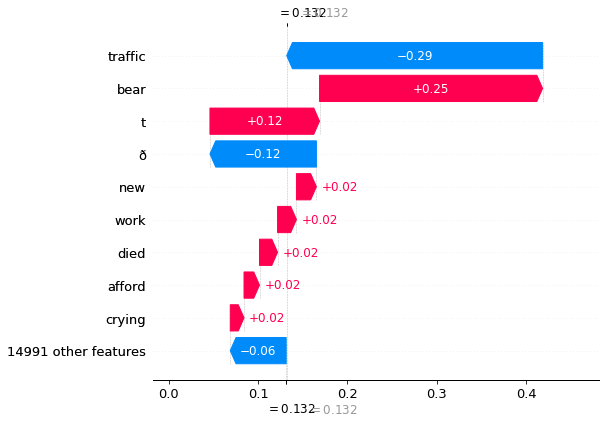

Tweet 4/10
Real sentiment: 1
Predicted sentiment: 0
@rothairisbeoir @__kbaker__ @cullen_ellen @willdesigndub @dublincycling @DubCityCouncil Aw man. And there I was, for just a moment, so happy.


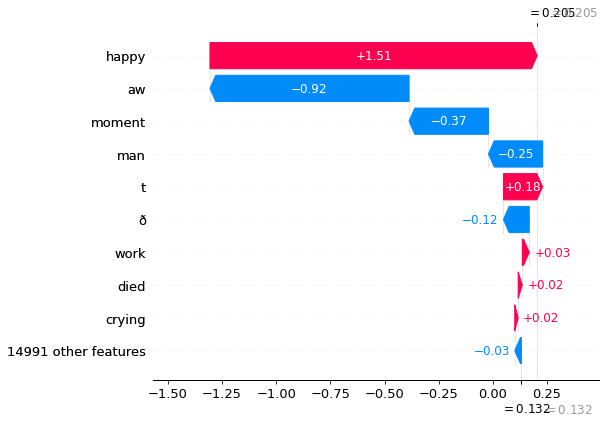

Tweet 5/10
Real sentiment: 1
Predicted sentiment: 0
@OConnorOisin @TUDublinEPS @IrishPedestrian @LorraineFitzsim @UCDRUP @DublinCommuters High Street  .. 6 lane urban motorway through Medieval city


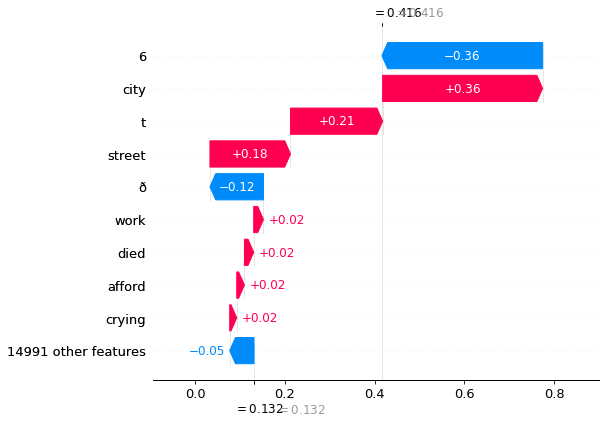

Tweet 6/10
Real sentiment: 1
Predicted sentiment: 0
RT @ChildRightsIRL: In 1919, The Democratic Programme of the First DÃ¡il promised âIt shall be the first duty of the Government of the Repubâ¦


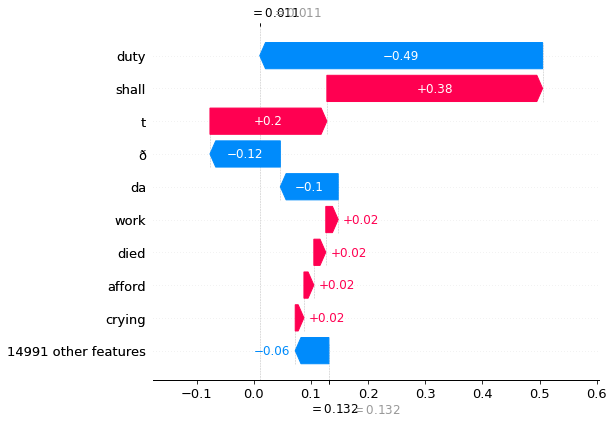

Tweet 7/10
Real sentiment: 1
Predicted sentiment: 0
Evo Morales is still the legal president of Bolivia as his resignation was not legally accepted by an elected government. The UN must act now,


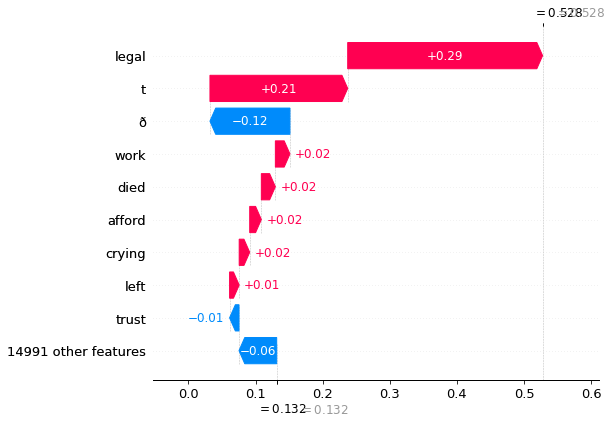

Tweet 8/10
Real sentiment: 1
Predicted sentiment: 0
@ShayBrennan @dlrcc @DublinVelo2019 @DublinCommuters @dlrcycling @IBIKEDublin @Cyclistie @dlbcycles @Greenaer We might be able to help with the clothing issueð


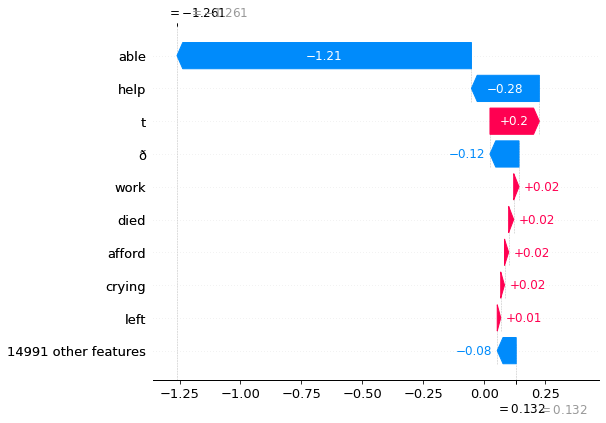

Tweet 9/10
Real sentiment: 1
Predicted sentiment: 0
@DubCham Finally. Good on you Dublin Chamber - this will solve the long standing white water rafting crisis that has gripped our beloved capital.


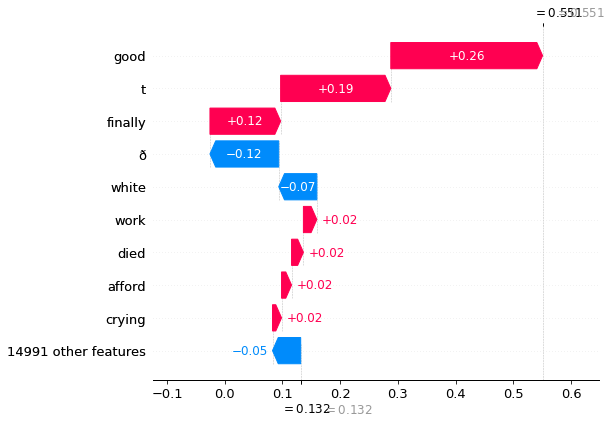

Tweet 10/10
Real sentiment: 1
Predicted sentiment: 0
@Ciara87C Dublin city council must have seen that mumsnet review saying thereâs nothing to do in Dublin and decided to take immediate action.  Keeping the tourists happy should be the top priority.


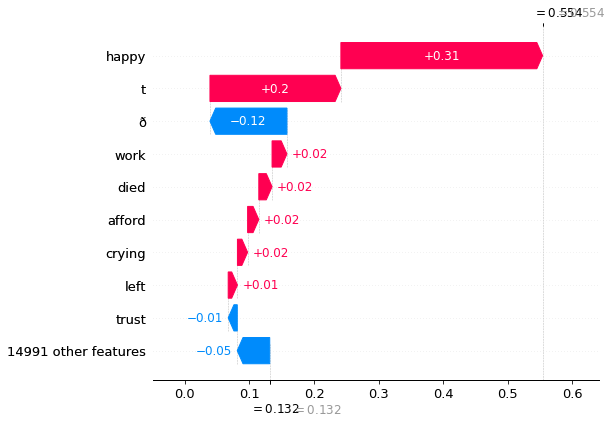

In [71]:
for i in range(N_TWEET_PRINT):
    y_true_n = df_dublin[df_dublin['sentiment'] != df_dublin['sentiment_pred_class']].loc[mask[i], 'sentiment']
    y_pred_n = df_dublin[df_dublin['sentiment'] != df_dublin['sentiment_pred_class']].loc[mask[i], 'sentiment_pred_class']
    print(f"Tweet {i+1}/{N_TWEET_PRINT}")
    print(f"Real sentiment: {y_true_n}")
    print(f"Predicted sentiment: {y_pred_n}")
    print(df_dublin[df_dublin['sentiment'] != df_dublin['sentiment_pred_class']].loc[mask[i], 'text'])
    shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[i], feature_names=word_vectorizer.get_feature_names())